In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

In [15]:
tasks = ["gent", "gents", "genr", "completion", "refinement"]
dataset = "rico"
task = tasks[0]
input_format = "seq"
output_format = "html"
add_unk_token = False
add_index_token = True
add_sep_token = True
candidate_size = -1  # -1 represents the complete training set
num_prompt = 2

In [19]:
import sys
from pathlib import Path
# src 디렉토리 경로 추가
src_path = Path("../src")  # notebooks에서 src로 이동하는 상대 경로
sys.path.append(str(src_path))

# Process raw data

In [16]:
import os

from preprocess import create_processor
from utils import RAW_DATA_PATH, read_pt, write_pt
from tqdm import tqdm


processor = create_processor(dataset=dataset, task=task)
base_dir = os.path.dirname(os.getcwd())


def get_processed_data(split):
    filename = os.path.join(
        base_dir, "dataset", dataset, "processed", task, f"{split}.pt"
    )
    if os.path.exists(filename):
        processed_data = read_pt(filename)
    else:
        processed_data = []
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        raw_path = os.path.join(RAW_DATA_PATH(dataset), f"{split}.pt")
        raw_data = read_pt(raw_path)
        for rd in tqdm(raw_data, desc=f"{split} data processing..."):
            processed_data.append(processor(rd))
        write_pt(filename, processed_data)
    return processed_data


processed_train_data = get_processed_data("train")
processed_val_data = get_processed_data("val")
processed_test_data = get_processed_data("test")

# Dynamic exemplar selection

In [17]:
from selection import create_selector

selector = create_selector(
    task=task,
    train_data=processed_train_data,
    candidate_size=candidate_size,
    num_prompt=num_prompt,
)

test_idx = 0
exemplars = selector(processed_test_data[test_idx])

# Input-output serialization

In [45]:
from origin_serialization import create_serializer, build_prompt

serializer = create_serializer(
    dataset=dataset,
    task=task,
    input_format=input_format,
    output_format=output_format,
    add_index_token=add_index_token,
    add_sep_token=add_sep_token,
    add_unk_token=add_unk_token
)
prompt = build_prompt(serializer, exemplars, processed_test_data[test_idx], dataset)

In [46]:
print(prompt)

Please generate a layout based on the given information. You need to ensure that the generated layout looks realistic, with elements well aligned and avoiding unnecessary overlap.
Task Description: generation conditioned on given element types
Layout Domain: android layout
Canvas Size: canvas width is 90px, canvas height is 160px

Element Type Constraint: background image 0 | icon 1 | image 2 | image 3 | image 4 | text 5 | text 6 | text 7 | text 8 | text 9 | text 10 | text 11 | text button 12 | text button 13 | text button 14
<html>
<body>
<div class="canvas" style="left: 0px; top: 0px; width: 90px; height: 160px"></div>
<div class="background image" style="index: 0; left: 0px; top: 0px; width: 90px; height: 160px"></div>
<div class="icon" style="index: 1; left: 79px; top: 3px; width: 8px; height: 9px"></div>
<div class="image" style="index: 2; left: 2px; top: 3px; width: 6px; height: 7px"></div>
<div class="image" style="index: 3; left: 31px; top: 85px; width: 26px; height: 4px"></div

# Call GPT

In [ ]:
modeltype = "gpt-4o-mini"
# modeltype = "gpt-3.5-turbo-instruct"
temperature = 0.7
max_tokens = 800
top_p = 1
frequency_penalty = 0
presence_penalty = 0
num_return = 1
stop_token = "\n\n"
# ENTER API KEY
os.environ["OPENAI_API_KEY"] = ""

In [47]:
response = client.completions.create(
    model=model,
    prompt=prompt,
    temperature=temperature,
    max_tokens=max_tokens,
    top_p=top_p,
    frequency_penalty=frequency_penalty,
    presence_penalty=presence_penalty,
    n=num_return,
    stop=[stop_token],
)

In [48]:
print(response.choices[0].text.strip())

<html>
<body>
<div class="canvas" style="left: 0px; top: 0px; width: 90px; height: 160px"></div>
<div class="image" style="index: 0; left: 0px; top: 0px; width: 90px; height: 160px"></div>
<div class="image" style="index: 1; left: 30px; top: 5px; width: 30px; height: 30px"></div>
<div class="image" style="index: 2; left: 30px; top: 40px; width: 30px; height: 30px"></div>
<div class="image" style="index: 3; left: 30px; top: 75px; width: 30px; height: 30px"></div>
<div class="pager indicator" style="index: 4; left: 40px; top: 120px; width: 10px; height: 10px"></div>
<div class="text" style="index: 5; left: 5px; top: 90px; width: 80px; height: 20px"></div>
<div class="text" style="index: 6; left: 5px; top: 130px; width: 80px; height: 20px"></div>
<div class="text button" style="index: 7; left: 10px; top: 110px; width: 20px; height: 10px"></div>
<div class="text button" style="index: 8; left: 60px; top: 110px; width: 20px; height: 10px"></div>
</body>
</html>


In [51]:
parser = Parser(dataset=dataset, output_format=output_format)
parsed_response = parser(response)
print(f"filter {num_return - len(parsed_response)} invalid response")

filter -971 invalid response


# 추론

In [55]:
from origin_serialization import create_serializer, build_prompt
import pandas as pd
from openai import OpenAI
from gpt_parsing import Gpt_parser

all_results_df = pd.DataFrame(columns=['test_idx', 'response'])

selector = create_selector(
    task=task,
    train_data=processed_train_data,
    candidate_size=candidate_size,
    num_prompt=num_prompt,
)

serializer = create_serializer(
    dataset=dataset,
    task=task,
    input_format=input_format,
    output_format=output_format,
    add_index_token=add_index_token,
    add_sep_token=add_sep_token,
    add_unk_token=add_unk_token
)
parser = Gpt_parser(dataset=dataset, output_format=output_format)
client = OpenAI()

for test_idx in range(101):
    test_data = processed_test_data[test_idx]
    exemplars = selector(test_data)

    prompt = build_prompt(serializer, exemplars,  test_data, dataset)
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": [
                {"type" : "text","text" : f"{prompt}",}
                ]}],
                temperature = temperature,
                top_p = top_p,
                frequency_penalty = frequency_penalty,
                presence_penalty = presence_penalty)
    # Parse and store the response
    try:
        if response is not None:
            parsed_response = parser(response)
            result_df = pd.DataFrame({
                'test_idx': [test_idx],
                'response': [parsed_response]
            })

            all_results_df = pd.concat([all_results_df, result_df], ignore_index=True)
    except AttributeError:
        print("div_tag is None, skipping find_all()")
    

div_tag is None, skipping find_all()


In [ ]:
print(response)

ChatCompletion(id='chatcmpl-Acoo6bXlT9goe3dKnEUZJldfHfiXU', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Based on the provided information, I will create a realistic Android layout that adheres to the specified constraints. The layout will be visually organized and all elements will be properly aligned within the canvas size of 90px width and 160px height.\n\n### Android Layout Layout\n\n```html\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 90px; height: 160px; position: relative; border: 1px solid #000;">\n    <div class="toolbar" style="index: 0; left: 0px; top: 0px; width: 90px; height: 13px; background-color: #ddd; position: absolute;"></div>\n    <div class="image" style="index: 1; left: 2px; top: 15px; width: 86px; height: 40px; background-image: url(\'image1.png\'); background-size: cover; position: absolute;"></div>\n    <div class="image" style="index: 2; left: 2px; top: 58px; width: 86px; height

# Parsing

In [25]:
from parsing import Parser


parser = Parser(dataset=dataset, output_format=output_format)
parsed_response = parser(response)
print(f"filter {num_return - len(parsed_response)} invalid response")

filter 0 invalid response


# Layout ranking

In [26]:
from ranker import Ranker

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)
ranked_response = ranker(parsed_response)

In [27]:
parsed_response

[(tensor([ 2,  2,  2,  2, 16,  1,  1,  5,  5]),
  tensor([[0.0556, 0.0312, 0.3333, 0.3125],
          [0.5000, 0.0312, 0.4444, 0.2500],
          [0.0556, 0.3750, 0.4444, 0.2500],
          [0.5000, 0.3750, 0.4444, 0.2500],
          [0.3889, 0.6875, 0.2222, 0.0625],
          [0.0556, 0.8125, 0.2778, 0.0625],
          [0.3889, 0.8125, 0.2778, 0.0625],
          [0.0556, 0.9375, 0.4444, 0.0625],
          [0.5000, 0.9375, 0.4444, 0.0625]])),
 (tensor([ 2,  2,  2,  2, 16,  1,  1,  5,  5]),
  tensor([[0.0333, 0.0625, 0.9333, 0.5000],
          [0.0333, 0.5750, 0.9333, 0.2500],
          [0.0333, 0.8375, 0.9333, 0.1250],
          [0.0333, 0.9625, 0.9333, 0.0375],
          [0.4222, 0.9250, 0.1556, 0.0250],
          [0.0556, 0.0312, 0.8889, 0.0250],
          [0.0556, 0.7500, 0.8889, 0.0250],
          [0.2222, 0.6625, 0.5556, 0.0625],
          [0.2222, 0.8375, 0.5556, 0.0625]])),
 (tensor([ 2,  2,  2,  2, 16,  1,  1,  5,  5]),
  tensor([[0.1667, 0.0938, 0.6667, 0.1875],
          [0.1

# 평가

In [56]:
# calculate_ssim
from ranker import Ranker
from imgMetrics import calculate_ssim
from visualization import Visualizer

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)

visualizer = Visualizer(dataset)
length  = len(all_results_df)
ssimScores = []

for test_idx in range(length):
    response_values = all_results_df.loc[all_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        continue

    response_for_test_idx = response_values[0]
    if (response_for_test_idx == [[]] or (len(response_for_test_idx) == 0) or (len(response_for_test_idx[0][0]) == 0)):
        continue
    test_data = processed_test_data[test_idx]
    labels = test_data['labels']
    bboxes = test_data['bboxes']
    generated_images = visualizer([(labels, bboxes)])
    testimg = generated_images[0]

    ranked_response = ranker(response_for_test_idx)
    response = ranked_response[0]
    labels = response[0]  # response[0]은 라벨 텐서
    bboxes = response[1]  # response[1]은 바운딩 박스 텐서
    generated_images = visualizer([(labels, bboxes)])
    inferenceImg = generated_images[0]
    score = calculate_ssim(testimg, inferenceImg)
    ssimScores.append(score)

No data for test_idx 68, skipping.


In [57]:
import numpy as np
np.mean(ssimScores)

0.7449612699035326

In [64]:
# calculate fid
from ranker import Ranker
from imgMetrics import calculate_fid

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)

visualizer = Visualizer(dataset)
length  = len(all_results_df)
fidScores = []

for test_idx in range(length):
    response_values = all_results_df.loc[all_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        continue

    response_for_test_idx = response_values[0]
    if (response_for_test_idx == [[]] or (len(response_for_test_idx) == 0) or (len(response_for_test_idx[0][0]) == 0)):
        continue
    test_data = processed_test_data[test_idx]
    labels = test_data['labels']
    bboxes = test_data['bboxes']
    generated_images = visualizer([(labels, bboxes)])
    testimg = generated_images[0]

    ranked_response = ranker(response_for_test_idx)
    response = ranked_response[0]
    labels = response[0]  # response[0]은 라벨 텐서
    bboxes = response[1]  # response[1]은 바운딩 박스 텐서
    generated_images = visualizer([(labels, bboxes)])
    inferenceImg = generated_images[0]
    score = calculate_fid(testimg, inferenceImg)
    fidScores.append(score)

c:\Users\didtn\.conda\envs\layoutprompter\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\didtn\.conda\envs\layoutprompter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No data for test_idx 68, skipping.


In [65]:
import numpy as np
np.mean(fidScores)

131.1785610765587

In [67]:
from utils import compute_maximum_iou, convert_ltwh_to_ltrb
## mIOU 결과값 출력
# 원본 데이터셋의 라벨 및 바운딩 박스
def mIOU(test_data, ranked_response):
    labels_1 = test_data['labels']
    bboxes_1 = test_data['bboxes']
    
    # 예측된 데이터셋의 라벨 및 바운딩 박스 리스트
    mIoUScroe = 0
    for response in ranked_response:
        labels_2 = response[0]  # response[0]은 라벨 텐서
        bboxes_2 = response[1]  # response[1]은 바운딩 박스 텐서
        # compute_maximum_iou 함수를 호출하여 최대 유사도 계산
        # _pred_labels = pred_labels.unsqueeze(0)
        # _pred_bboxes = convert_ltwh_to_ltrb(pred_bboxes).unsqueeze(0)
        iou_score = compute_maximum_iou(labels_1, bboxes_1, [labels_2], [bboxes_2])
        # 결과 출력
        if (iou_score > mIoUScroe):
            mIoUScroe = iou_score
            # print(f"Computed Maximum IOU Score: {iou_score}")
    # print(f"Max Score: {mIoUScroe}")
    return mIoUScroe

In [68]:
from utils import compute_overlap
import torch

def mOverlap(ranked_response):
    # 예측된 데이터셋의 라벨 및 바운딩 박스 리스트
    for response in ranked_response:
        labels_2 = response[0]  # response[0]은 라벨 텐서
        bboxes_2 = response[1]  # response[1]은 바운딩 박스 텐서

        _pred_labels = labels_2.unsqueeze(0)
        _pred_bboxes = convert_ltwh_to_ltrb(bboxes_2).unsqueeze(0)
        _pred_padding_mask = torch.ones_like(_pred_labels).bool()
        return compute_overlap(_pred_bboxes, _pred_padding_mask)

In [70]:
from ranker import Ranker
from utils import (
    compute_alignment,
    compute_maximum_iou,
    compute_overlap,
)

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)

outNum = 0
mIOUscore = 0
length  = len(all_results_df)
for test_idx in range(length):
    response_values = all_results_df.loc[all_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        outNum = outNum + 1
        continue

    response_for_test_idx = response_values[0]
    if (response_for_test_idx == [[]] or (len(response_for_test_idx) == 0) or (len(response_for_test_idx[0][0]) == 0)):
        outNum = outNum + 1
        continue
    ranked_response = ranker(response_for_test_idx)
    test_data = processed_test_data[test_idx]
    mIOUscore = mIOUscore + mIOU(test_data, ranked_response)

mIOUscore = mIOUscore / (length-outNum)

print(mIOUscore)

No data for test_idx 68, skipping.
0.44108948269142556


In [75]:
from imgMetrics import calculateOverlap
from imgMetrics import calculateAllignment

val_path = os.path.join(RAW_DATA_PATH(dataset), "val.pt")
ranker = Ranker(val_path=val_path)
totalOverlap = 0
totalAllign = 0
outNum = 0
length  = len(all_results_df)
for test_idx in range(length):
    response_values = all_results_df.loc[all_results_df['test_idx'] == test_idx, 'response'].values
    
    # 조회 결과가 비어있는지 확인하고, 비어있으면 건너뜀
    if len(response_values) == 0:
        print(f"No data for test_idx {test_idx}, skipping.")
        outNum = outNum + 1
        continue

    response_for_test_idx = response_values[0]
    if (response_for_test_idx == [[]] or (len(response_for_test_idx) == 0) or (len(response_for_test_idx[0][0]) == 0)):
        outNum = outNum + 1
        continue
    ranked_response = ranker(response_for_test_idx)
    
    totalOverlap = totalOverlap + calculateOverlap(ranked_response[0])
    totalAllign = totalAllign + calculateAllignment(ranked_response[0])
print("Overlap Score = " + str(totalOverlap/(length-outNum)))
print("Allign Score = " + str(totalAllign/(length-outNum)))

No data for test_idx 68, skipping.
Overlap Score = 0.27531176461623263
Allign Score = 0.002640174193612228


# Visualization

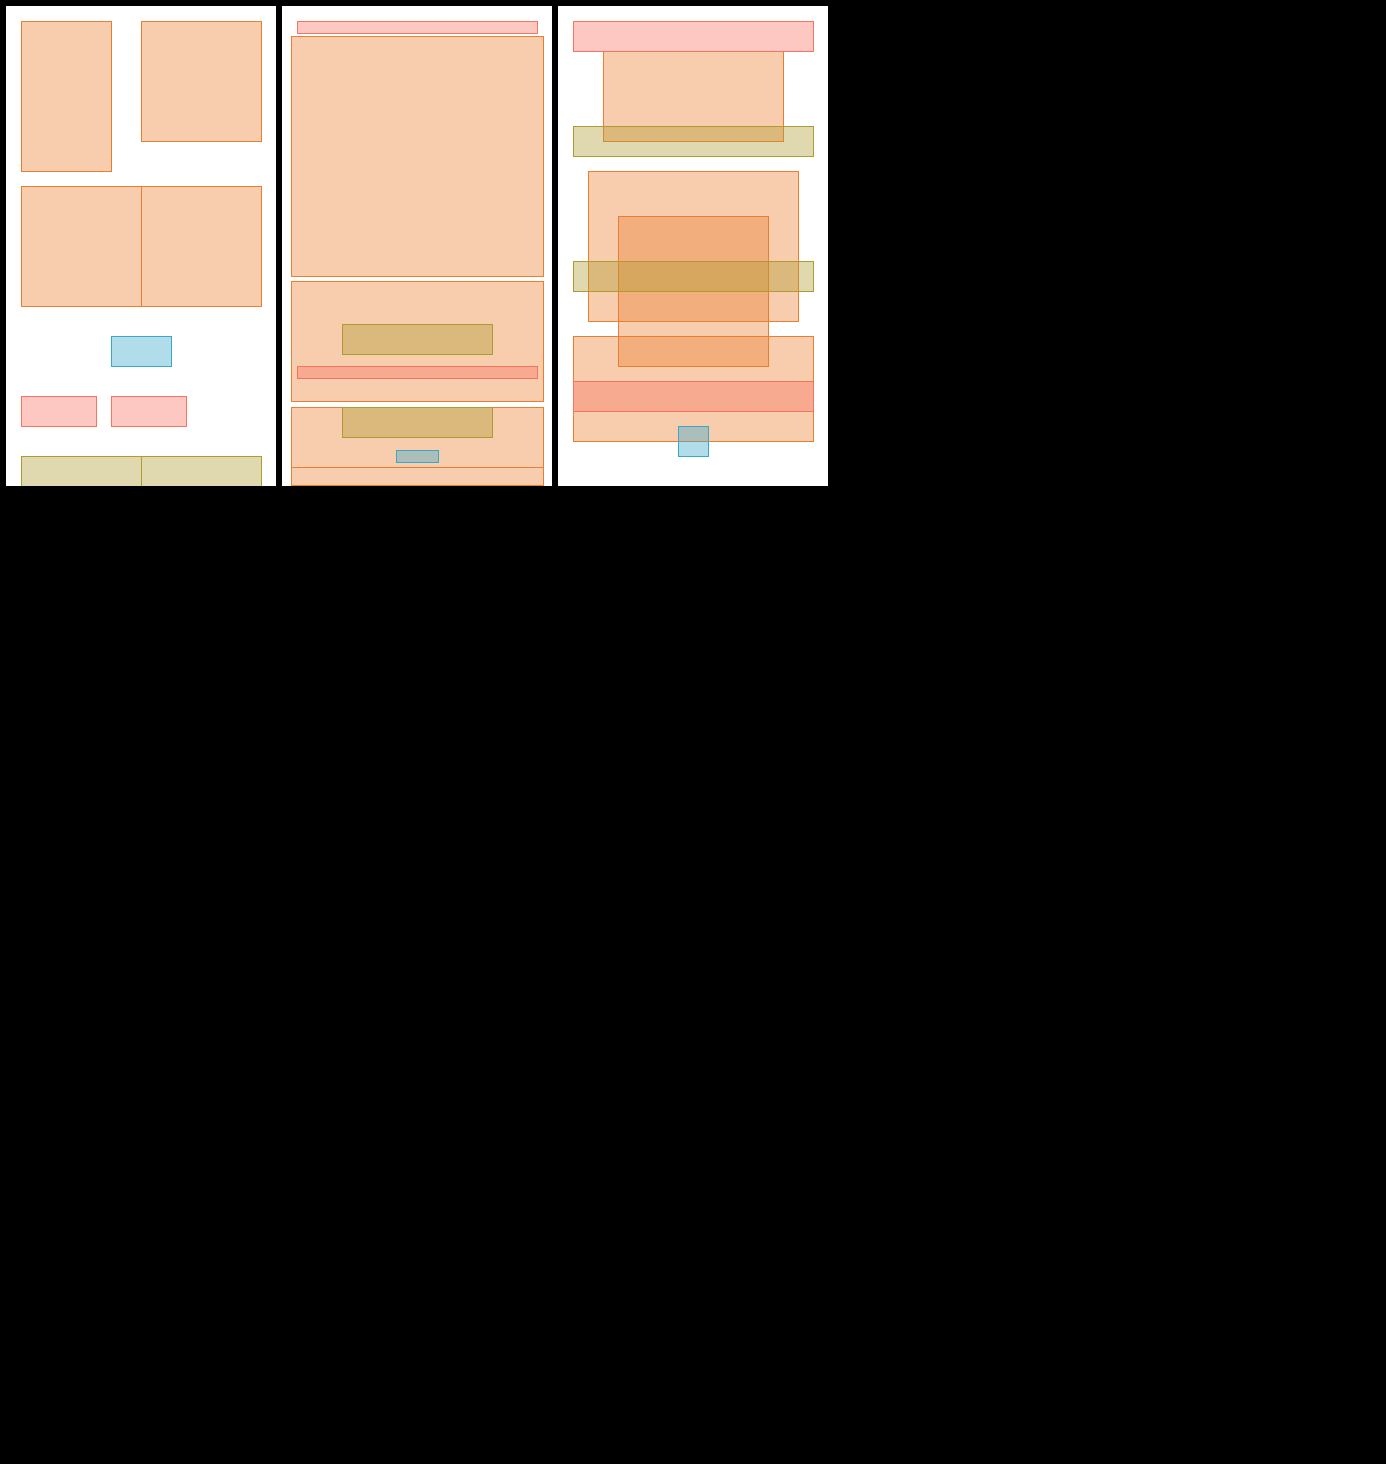

In [28]:
from visualization import Visualizer, create_image_grid


visualizer = Visualizer(dataset)
images = visualizer(ranked_response)
create_image_grid(images)